In [1]:
import os
os.chdir('../data/arma_generated/sample/')

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import moviepy.editor as mve
import pandas as pd
import seaborn as sns

In [48]:
def get_annotation(filename, frame_number):
    df = pd.read_csv(filename)
    start_time = df['timestamp'].min()
    df.objects = df.objects.apply(lambda lst: [(x,y) for _,x,y in eval(lst)])
    def is_bbox_in_scope(x, y):
        return 0 <= x <= 1280 and 0 <=  y <= 720

    df.objects = df.objects.apply(lambda bboxes: [bbox for bbox in bboxes if is_bbox_in_scope(*bbox)])
    df = df[df.objects.apply(lambda x: x!=[])]
    
    interest_time =  df.iloc[frame_number]['timestamp']
    interest_frame =  df.iloc[frame_number]['frame']
    interest_objs =  df.iloc[frame_number]['objects']
    return start_time, interest_time, interest_frame, interest_objs

In [4]:
start_time, interest_time, interest_frame, interest_objs = get_annotation('./3.csv', 194)

In [5]:
print(interest_time, start_time)

second = int(interest_time.split(':')[-1]) - int(start_time.split(':')[-1])
second

2018-11-24 11:16:51 2018-11-24 11:16:08


43

In [6]:
interest_objs

[(619.094, 409.103),
 (614.834, 406.942),
 (607.849, 394.265),
 (581.376, 363.385),
 (545.011, 504.292)]

In [7]:
def load_video_frame(filename, second, interest_frame, offset):
    cap = cv2.VideoCapture(filename)
    frames = []
    for i in range(second * 30 + int(interest_frame/15 * 30) + offset):
        ret, frame = cap.read()
        frames.append(frame)
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    cap.release()
    return frame

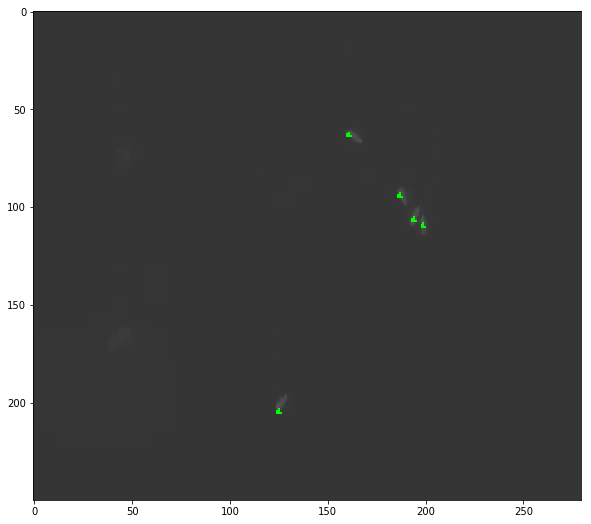

In [8]:
frame = load_video_frame("./2018-11-24 11-16-08.mp4", second, interest_frame, 8)

to_draw = frame.copy()
for x, y in interest_objs:
    x = int(x)
    y = int(y)
    #to_draw[y-2:y+2,x,1] = 255
    to_draw = cv2.drawMarker(to_draw, (x,y), (0,255,0), 5, 2)

plt.figure(figsize=(16,9))
plt.imshow(to_draw[300:550, 420:700,:])

In [13]:
img_col = frame.copy()
img_gray = cv2.cvtColor(img_col, cv2.COLOR_RGB2GRAY)

In [14]:
print(img_gray.min())
print(img_gray.max())

52
85


In [15]:
sns.distplot(np.asarray(frames[-10:]).flatten(), bins=256)

NameError: name 'frames' is not defined

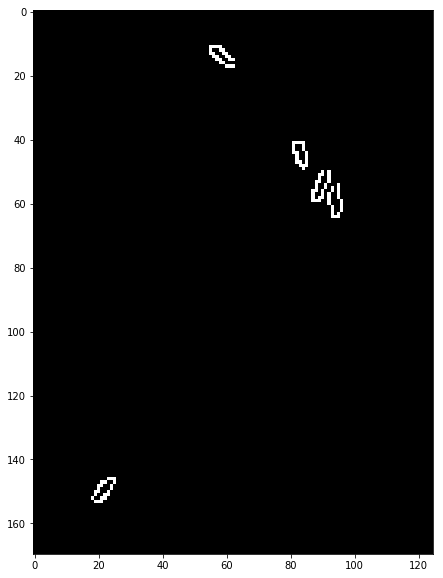

In [16]:
gg = cv2.Canny(img_gray, 40, 100)
plt.figure(figsize=(10,10))
plt.imshow(gg[350:520,525:650], cmap='gray')

In [17]:
hh, contours, hier = cv2.findContours(gg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contours = [cv2.convexHull(c) for c in contours]

len(contours)

5

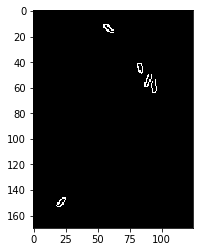

In [18]:
plt.imshow(hh[350:520,525:650], cmap='gray')

In [20]:
found_cnt = []
x, y = interest_objs[0]
x = int(x)
y = int(y)
print(x,y)
for cnt in contours:
    isincont = cv2.pointPolygonTest(cnt, (x,y), True) > 0
    if isincont:
        found_cnt.append(cnt)
len(found_cnt)

619 409


1

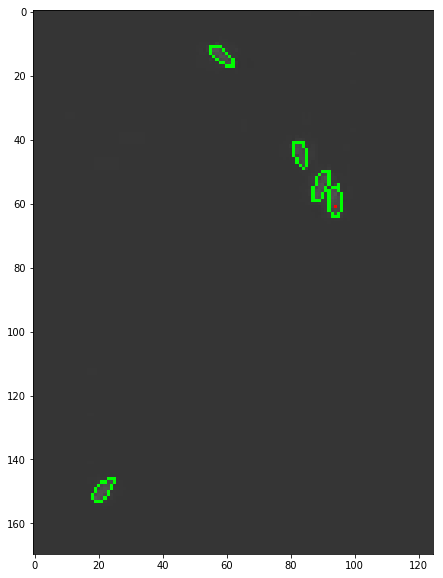

In [22]:
image = img_col.copy()
x, y = interest_objs[0]
x = int(x)
y = int(y)
cnts = [cv2.convexHull(cnt) for cnt in contours]
#cnts = contours
cv2.drawContours(image, cnts, -1, (0,255,0), 1)

rects = [cv2.boundingRect(cnt) for cnt in contours]

image[y+2,x,:] = np.asarray((255,0,0))

plt.figure(figsize=(10,10))
plt.imshow(image[350:520,525:650])

In [23]:
cv2.pointPolygonTest(contours[1], (x,y), True)

1.9611613513818404

In [25]:
cv2.pointPolygonTest(found_cnt[0], (x,y), True)

1.9611613513818404

In [28]:
res = []
for (int_x,int_y) in interest_objs:
    for c in contours:
        cnt = c.copy()
        dist = cv2.pointPolygonTest(cnt, (int_x,int_y), True)
        print(int_x, '---', cnt[:,:,0].min(), ',', cnt[:,:,0].max())
        print(int_y, '---', cnt[:,:,1].min(), ',', cnt[:,:,1].max())        
        if dist >= 0:
            res.append(((int_x, int_y), cnt))
            break
        elif dist < 2:
            print("Distance:",dist)

            print('enlarging contour')
            M = cv2.moments(cnt)
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            
            cnt = cnt.astype(np.float32)
            cnt[:,:,0] = 1.5*(cnt[:,:,0] - cX) + cX
            cnt[:,:,1] = 1.5*(cnt[:,:,1] - cY) + cY
            new_dist = cv2.pointPolygonTest(cnt, (int_x,int_y), True)
            print("New distance:", new_dist)
            if new_dist >= 0:
                res.append(((int_x, int_y), c))
                print("---ENLARGING SUCCEEDED")
                break
    print()
            
len(res)

619.094 --- 543 , 550
409.103 --- 496 , 503
Distance: -111.01832815754801
enlarging contour
New distance: -108.6013452992781
619.094 --- 617 , 621
409.103 --- 404 , 414

614.834 --- 543 , 550
406.942 --- 496 , 503
Distance: -110.15795646526391
enlarging contour
New distance: -107.77066109732709
614.834 --- 617 , 621
406.942 --- 404 , 414
Distance: -2.166792399422614
enlarging contour
New distance: -1.166015625
614.834 --- 612 , 617
406.942 --- 400 , 409

607.849 --- 543 , 550
394.265 --- 496 , 503
Distance: -117.03210641741141
enlarging contour
New distance: -114.7439017131101
607.849 --- 617 , 621
394.265 --- 404 , 414
Distance: -14.774394448654547
enlarging contour
New distance: -13.0169807920893
607.849 --- 612 , 617
394.265 --- 400 , 409
Distance: -9.111768314894327
enlarging contour
New distance: -8.07712106166218
607.849 --- 606 , 610
394.265 --- 391 , 399

581.376 --- 543 , 550
363.385 --- 496 , 503
Distance: -136.27614442782686
enlarging contour
New distance: -134.3655039925084

5

# Summary - bbox finding function

In [97]:
def find_bboxes(image, boar_points):
    image_gray = cv2.cvtColor(image.copy(), cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(image_gray, 40,100)
    cont_image, contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours = [cv2.convexHull(c) for c in contours]
    
    bboxes = []
    for x, y in boar_points:
        matching_contours = []
        all_contours = []
        for contour in contours:
            dist_from_contour = cv2.pointPolygonTest(contour, (x,y), True)
            if dist_from_contour >= 0:
                matching_contours.append({'contour': contour, 
                                          'area': cv2.contourArea(contour), 
                                          'distance': dist_from_contour})
            elif abs(dist_from_contour) <= 0.003 * min(image.shape[:2]):
                all_contours.append({'contour': contour,
                                     'area': cv2.contourArea(contour), 
                                     'distance': abs(dist_from_contour)})
        if matching_contours:
            contour = min(matching_contours, key=lambda x: x['area'])['contour']
            x, y, w, h = cv2.boundingRect(contour)
            bboxes.append((max(0, x-1), 
                           max(0, y-1),
                           min(image.shape[1], x+w+1),
                           min(image.shape[0], y+h+1)))
        elif all_contours:
            contour = min(all_contours, key=lambda x: x['distance'])['contour']
            x, y, w, h = cv2.boundingRect(contour)
            bboxes.append((max(0, x-1), 
                           max(0, y-1),
                           min(image.shape[1], x+w+1),
                           min(image.shape[0], y+h+1)))
    return bboxes

In [98]:
find_bboxes(img_col, interest_objs)

[(616, 403, 623, 416),
 (611, 399, 619, 411),
 (605, 390, 612, 401),
 (579, 360, 589, 369),
 (542, 495, 552, 505)]

In [99]:
def draw_bboxes(img_col, bboxes, ):
    to_draw = img_col.copy()
    to_draw = ((to_draw - to_draw.min()) / (to_draw.max() - to_draw.min()) * 255).astype(np.uint8)
    for bbox in bboxes:
        cv2.rectangle(to_draw,
                     (bbox[0], bbox[1]),
                     (bbox[2], bbox[3]),
                     (0,255,0))
    return to_draw

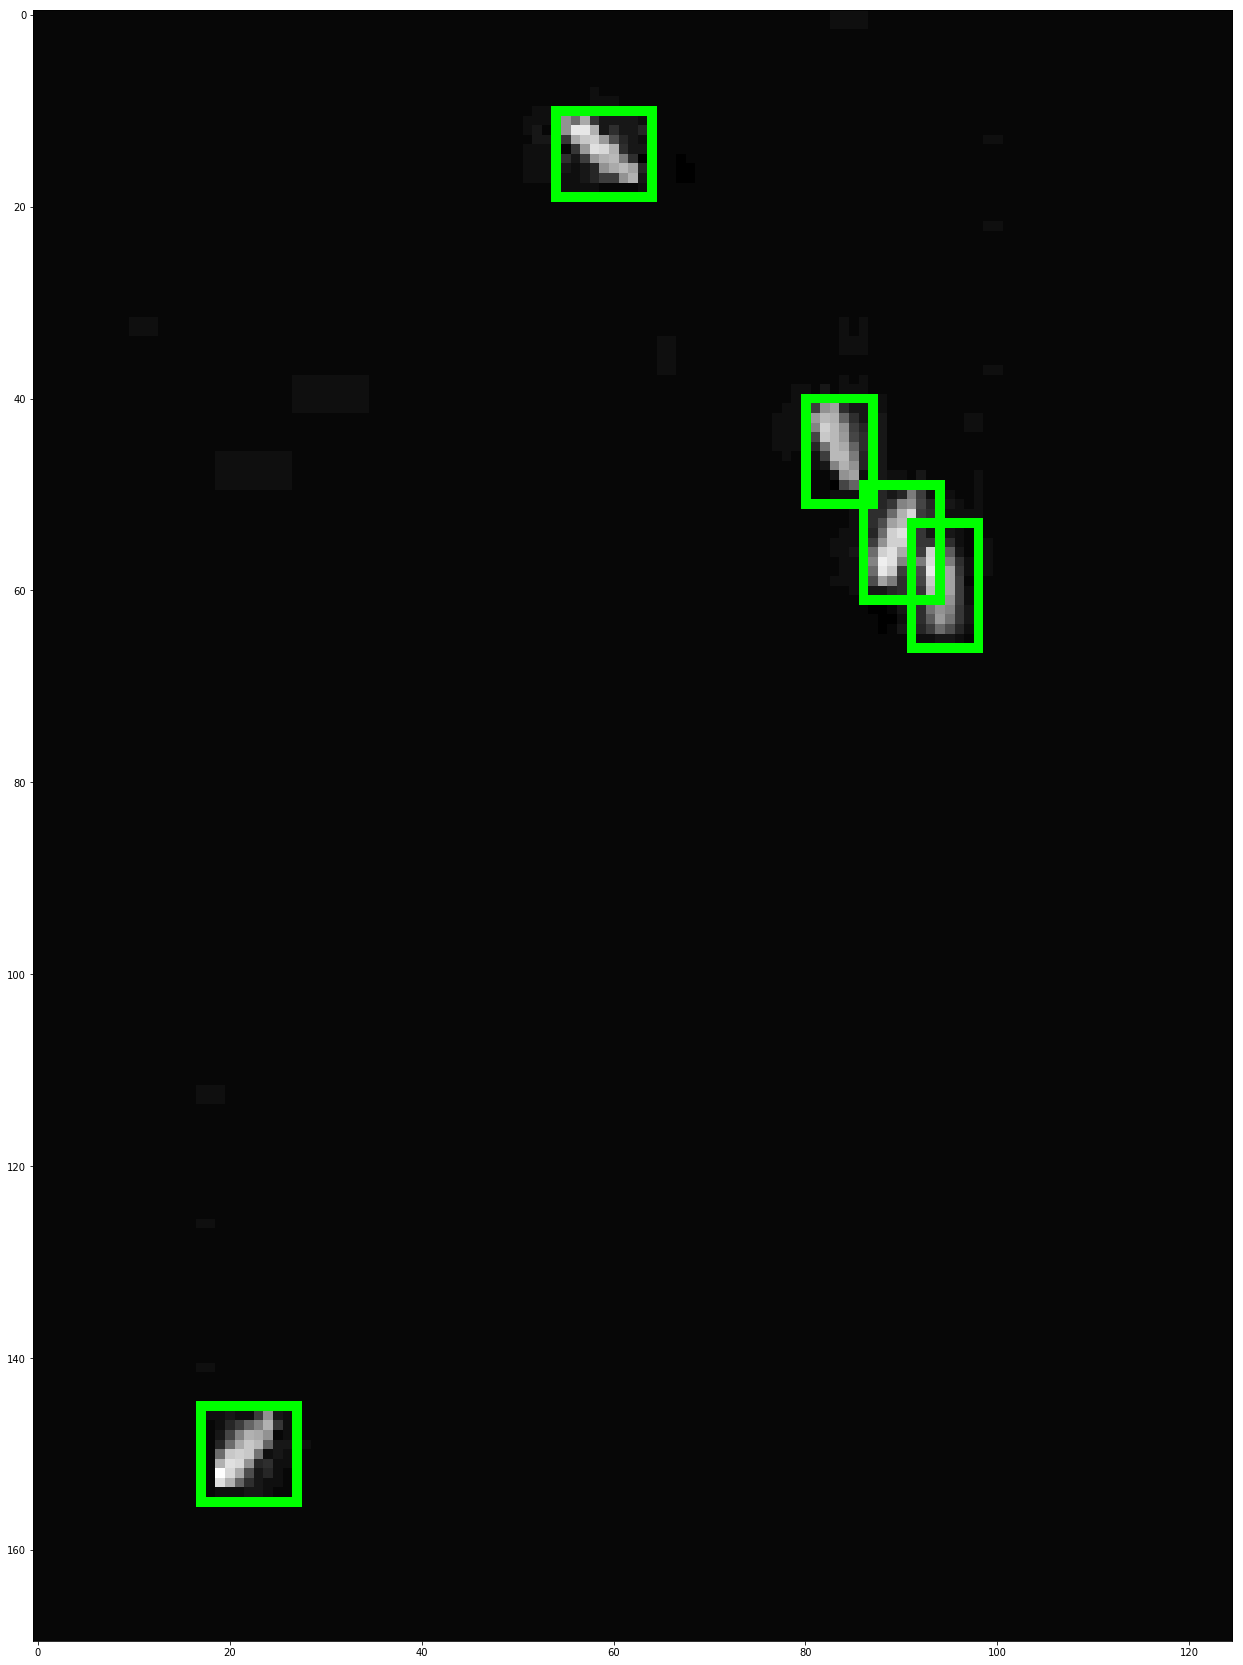

In [100]:
plt.figure(figsize=(30,30))
plt.imshow(draw_bboxes(img_col, find_bboxes(img_col, interest_objs))[350:520,525:650], cmap='gray')

# Test on another video

In [101]:
test_start_time, test_interest_time, test_interest_frame, test_interest_objs = get_annotation('./6.csv', 350)
test_start_time, test_interest_time

('2018-11-24 11:36:38', '2018-11-24 11:37:21')

In [102]:
print(test_interest_time, test_start_time)

second = int(test_interest_time.split(':')[-1]) - int(test_start_time.split(':')[-1])
if second < 0:
    minute = int(test_interest_time.split(':')[-2]) - int(test_start_time.split(':')[-2])
    second = 60 * minute + second
second

2018-11-24 11:37:21 2018-11-24 11:36:38


43

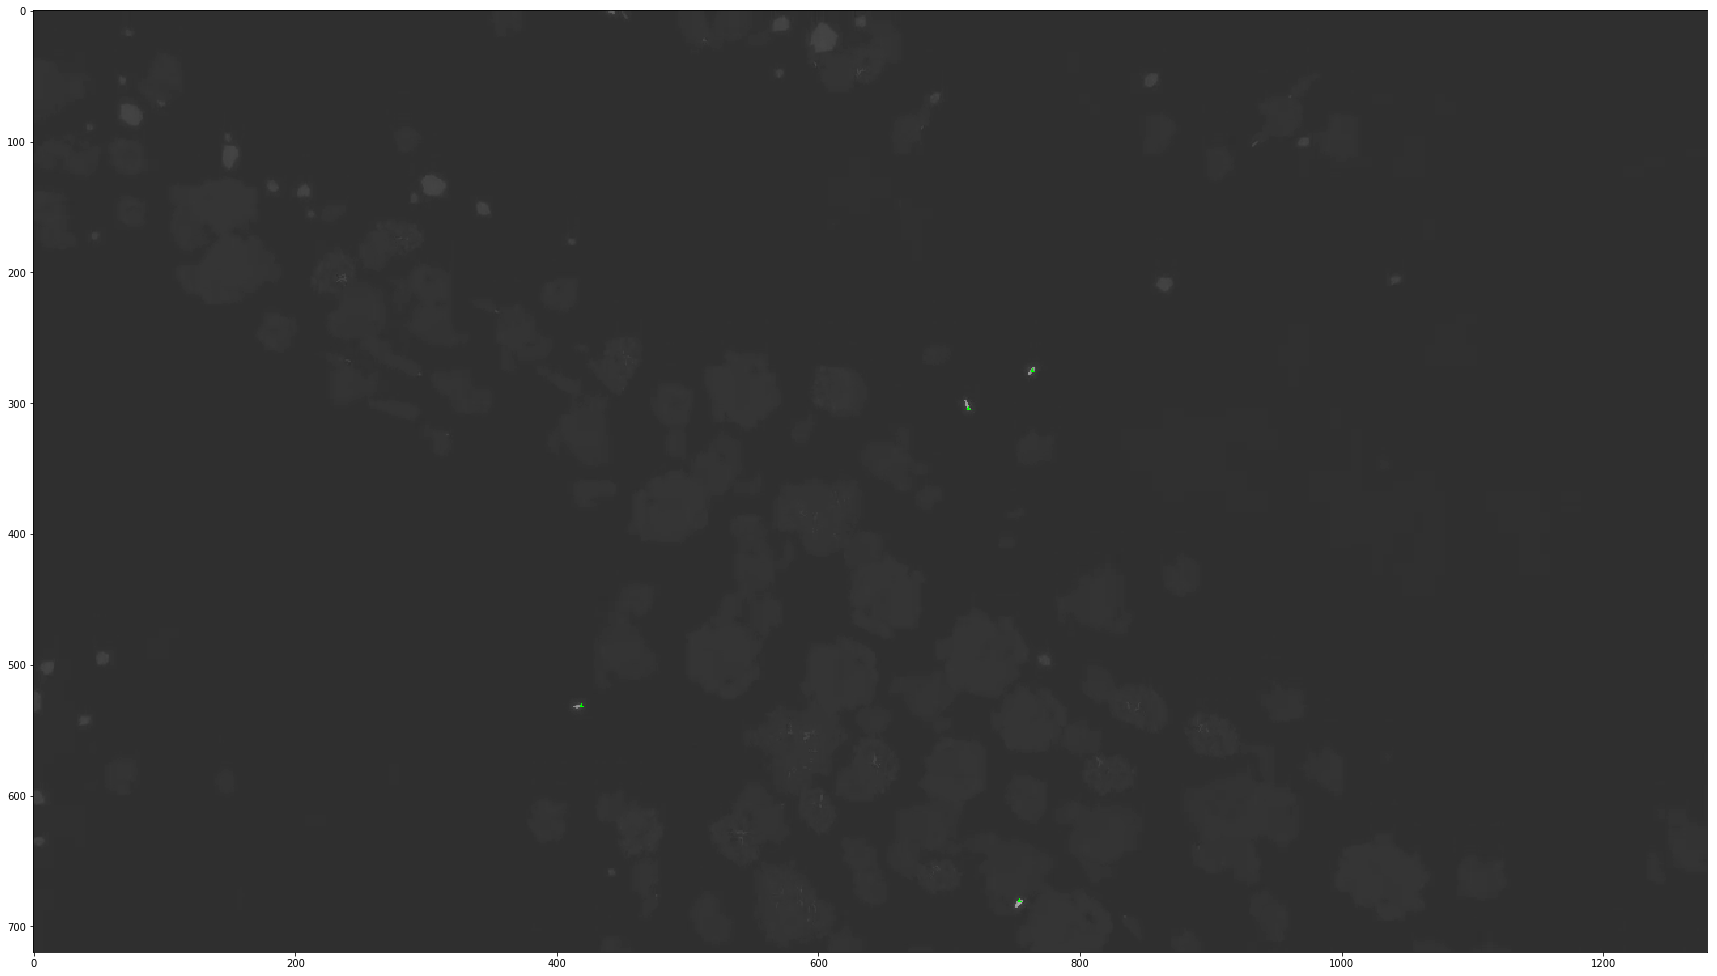

In [103]:
frame = load_video_frame("./2018-11-24 11-36-38.mp4", second, test_interest_frame, -12)

to_draw = frame.copy()
for x, y in test_interest_objs:
    x = int(x)
    y = int(y)
    #to_draw[y-2:y+2,x,1] = 255
    to_draw = cv2.drawMarker(to_draw, (x,y), (0,255,0), 5, 3)

plt.figure(figsize=(30,30))
plt.imshow(to_draw)

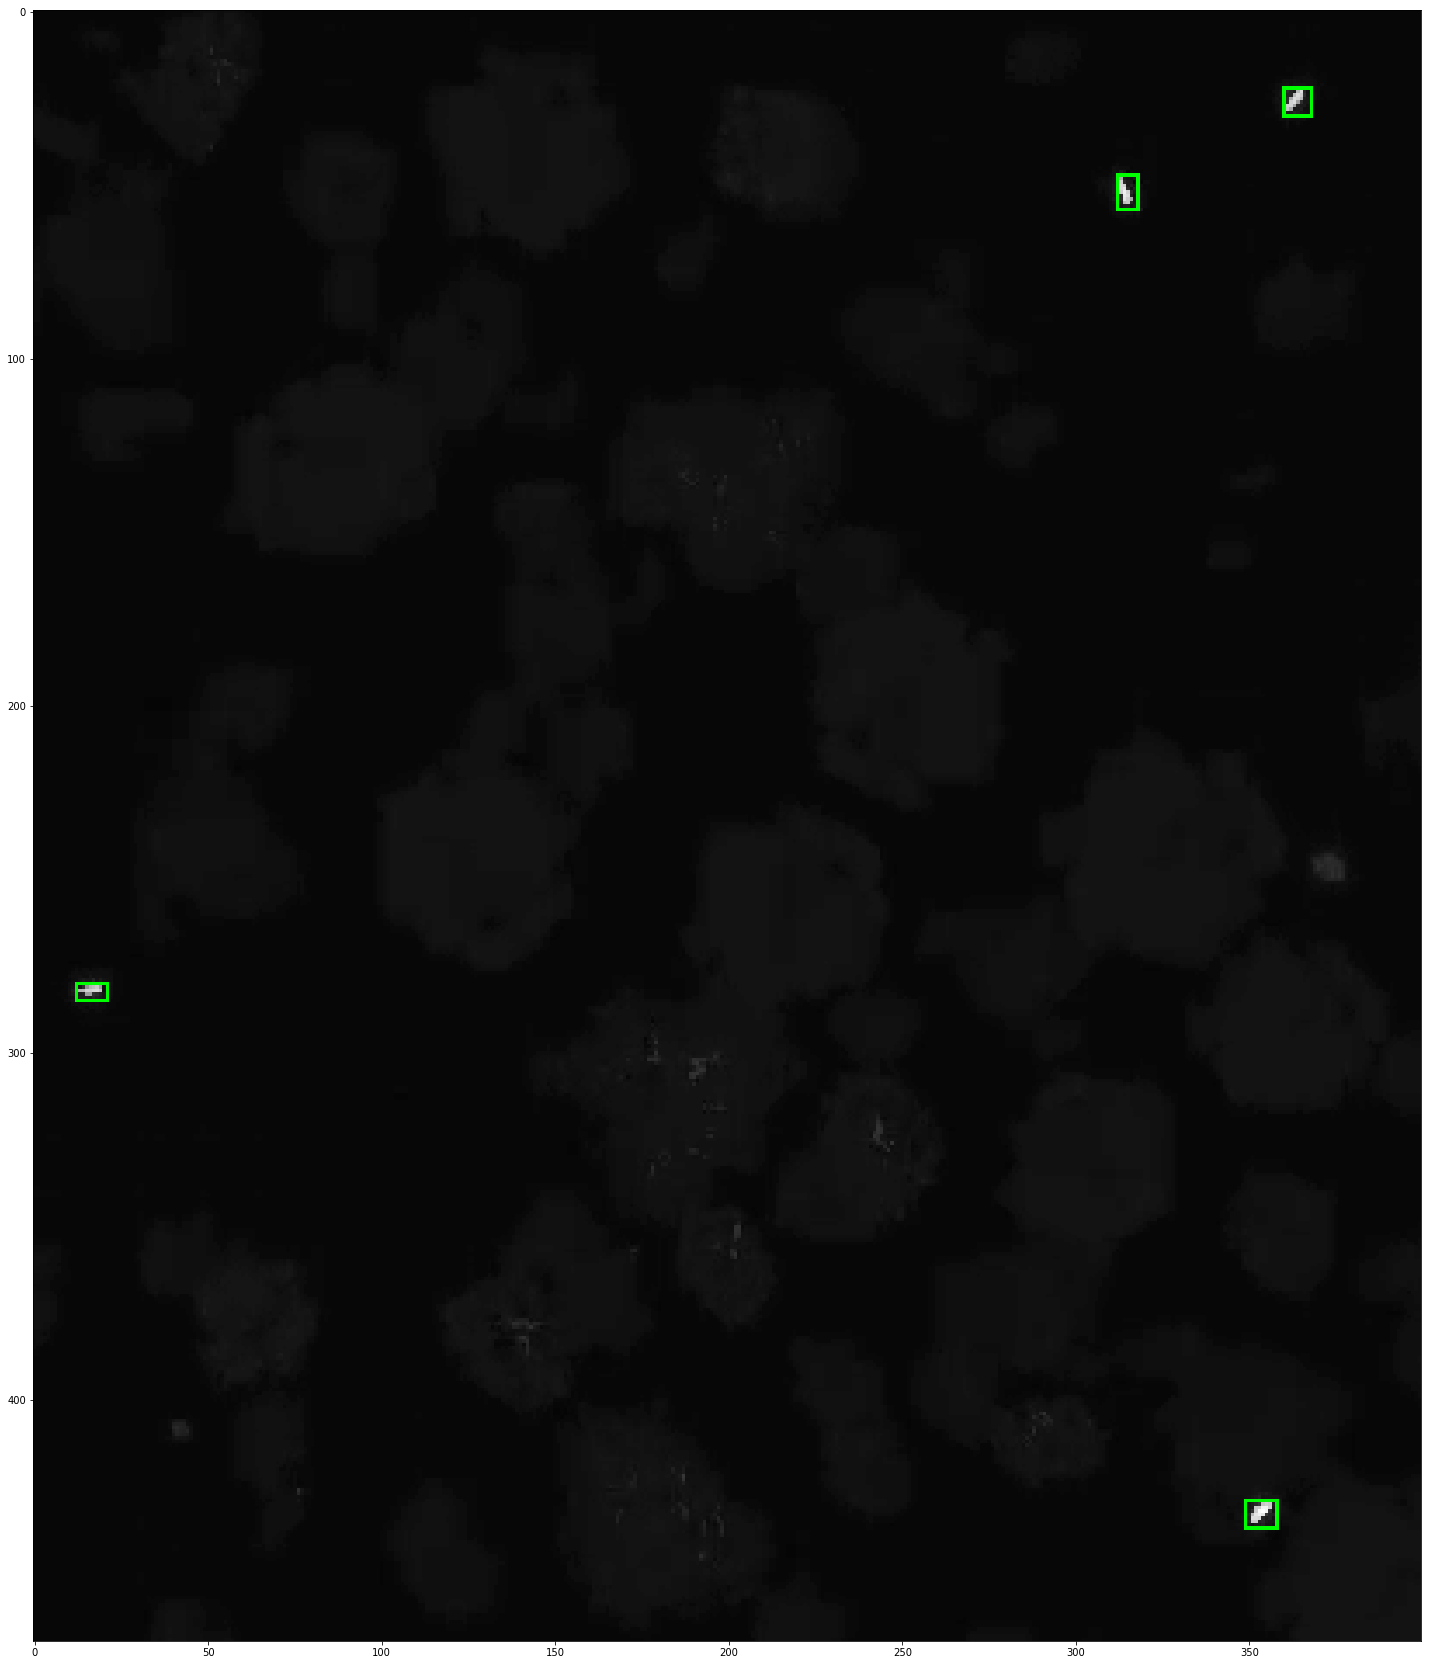

In [104]:
plt.figure(figsize=(30,30))
bb = find_bboxes(frame, test_interest_objs)
plt.imshow(draw_bboxes(frame, bb)[250:,400:800], cmap='gray')

In [105]:
def increase_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2RGB)
    return img

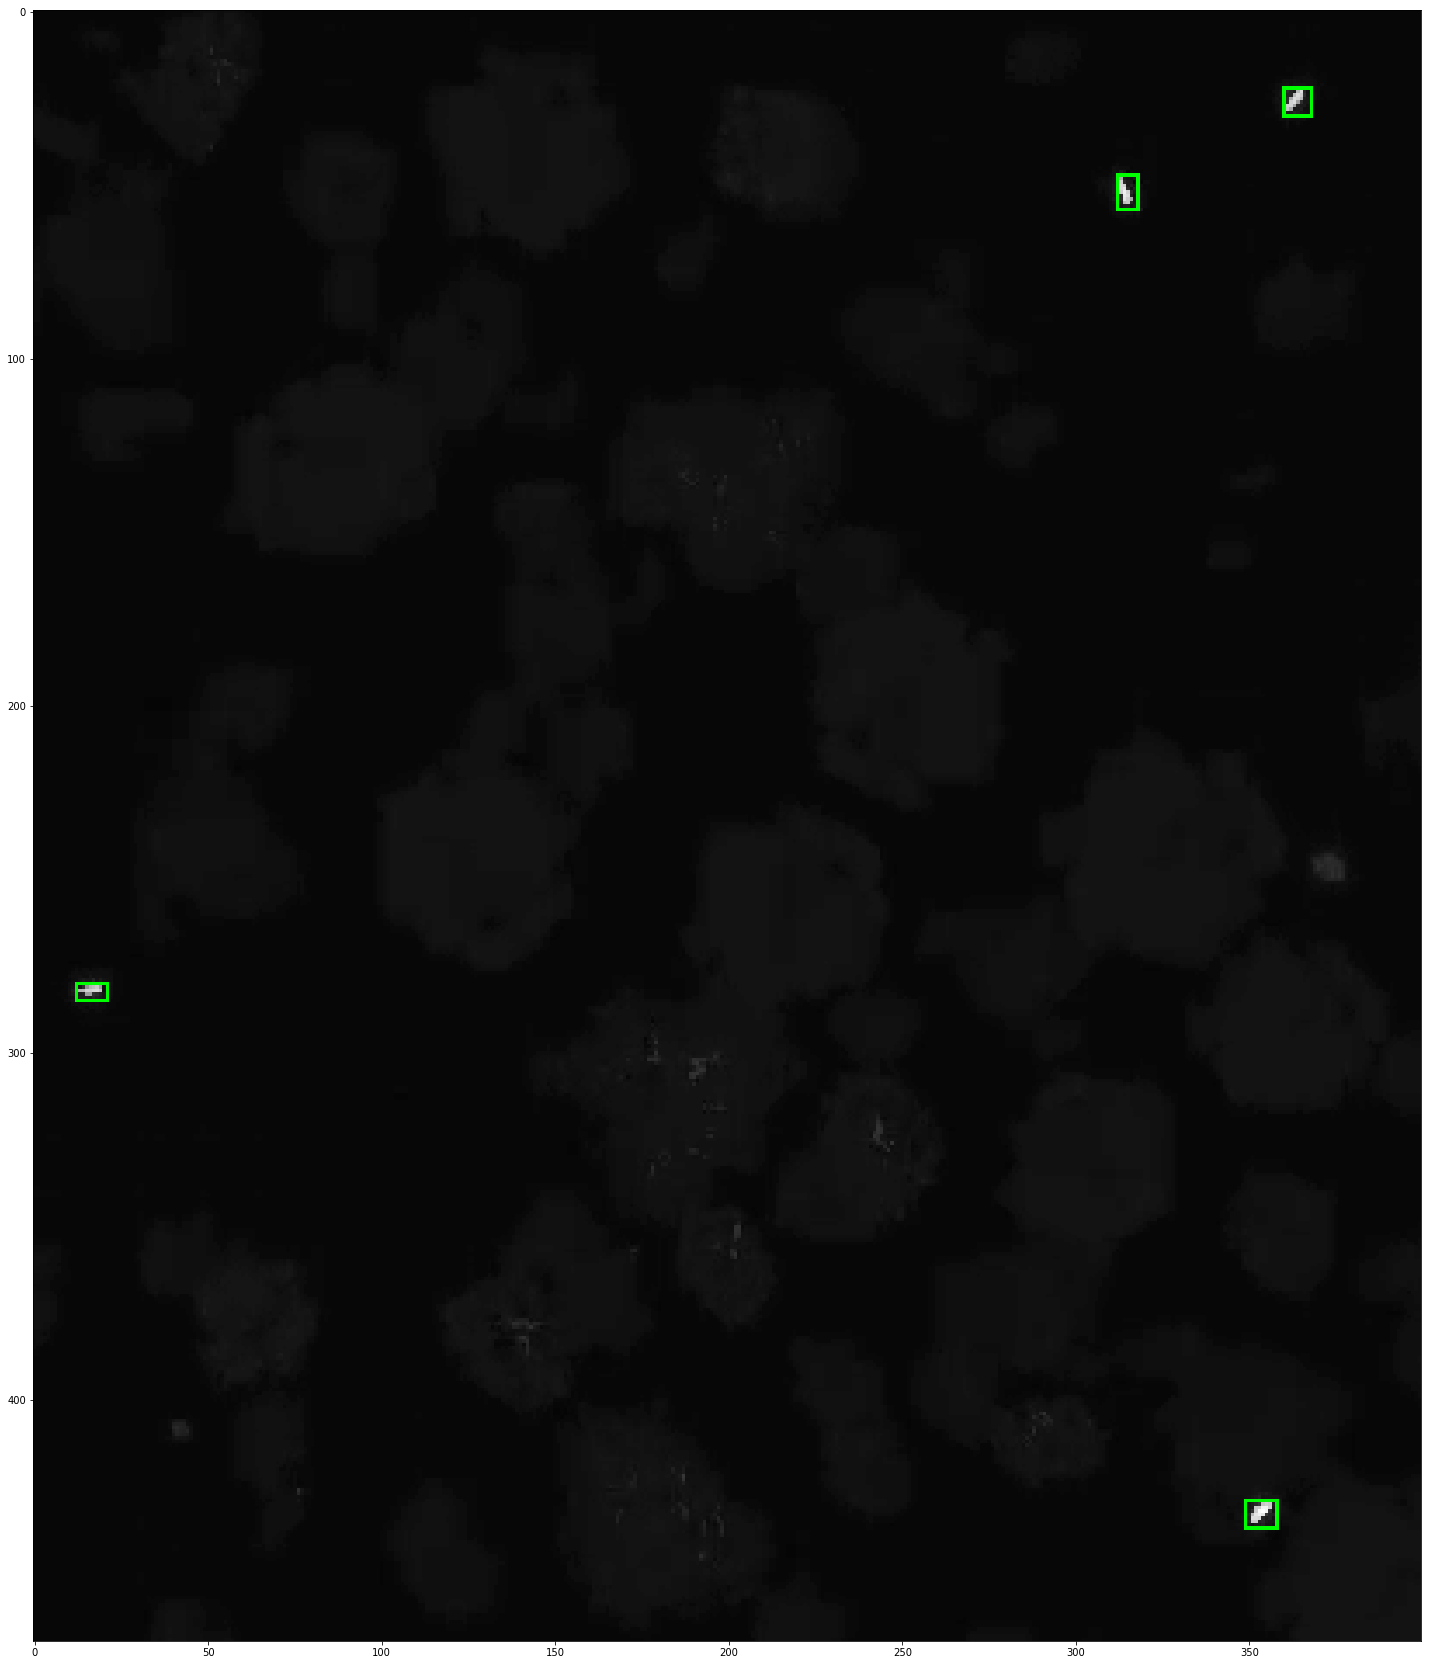

In [114]:
plt.figure(figsize=(30,30))
bb = find_bboxes(frame, test_interest_objs)
plt.imshow(draw_bboxes(increase_brightness(frame,0), bb)[250:,400:800], cmap='gray')

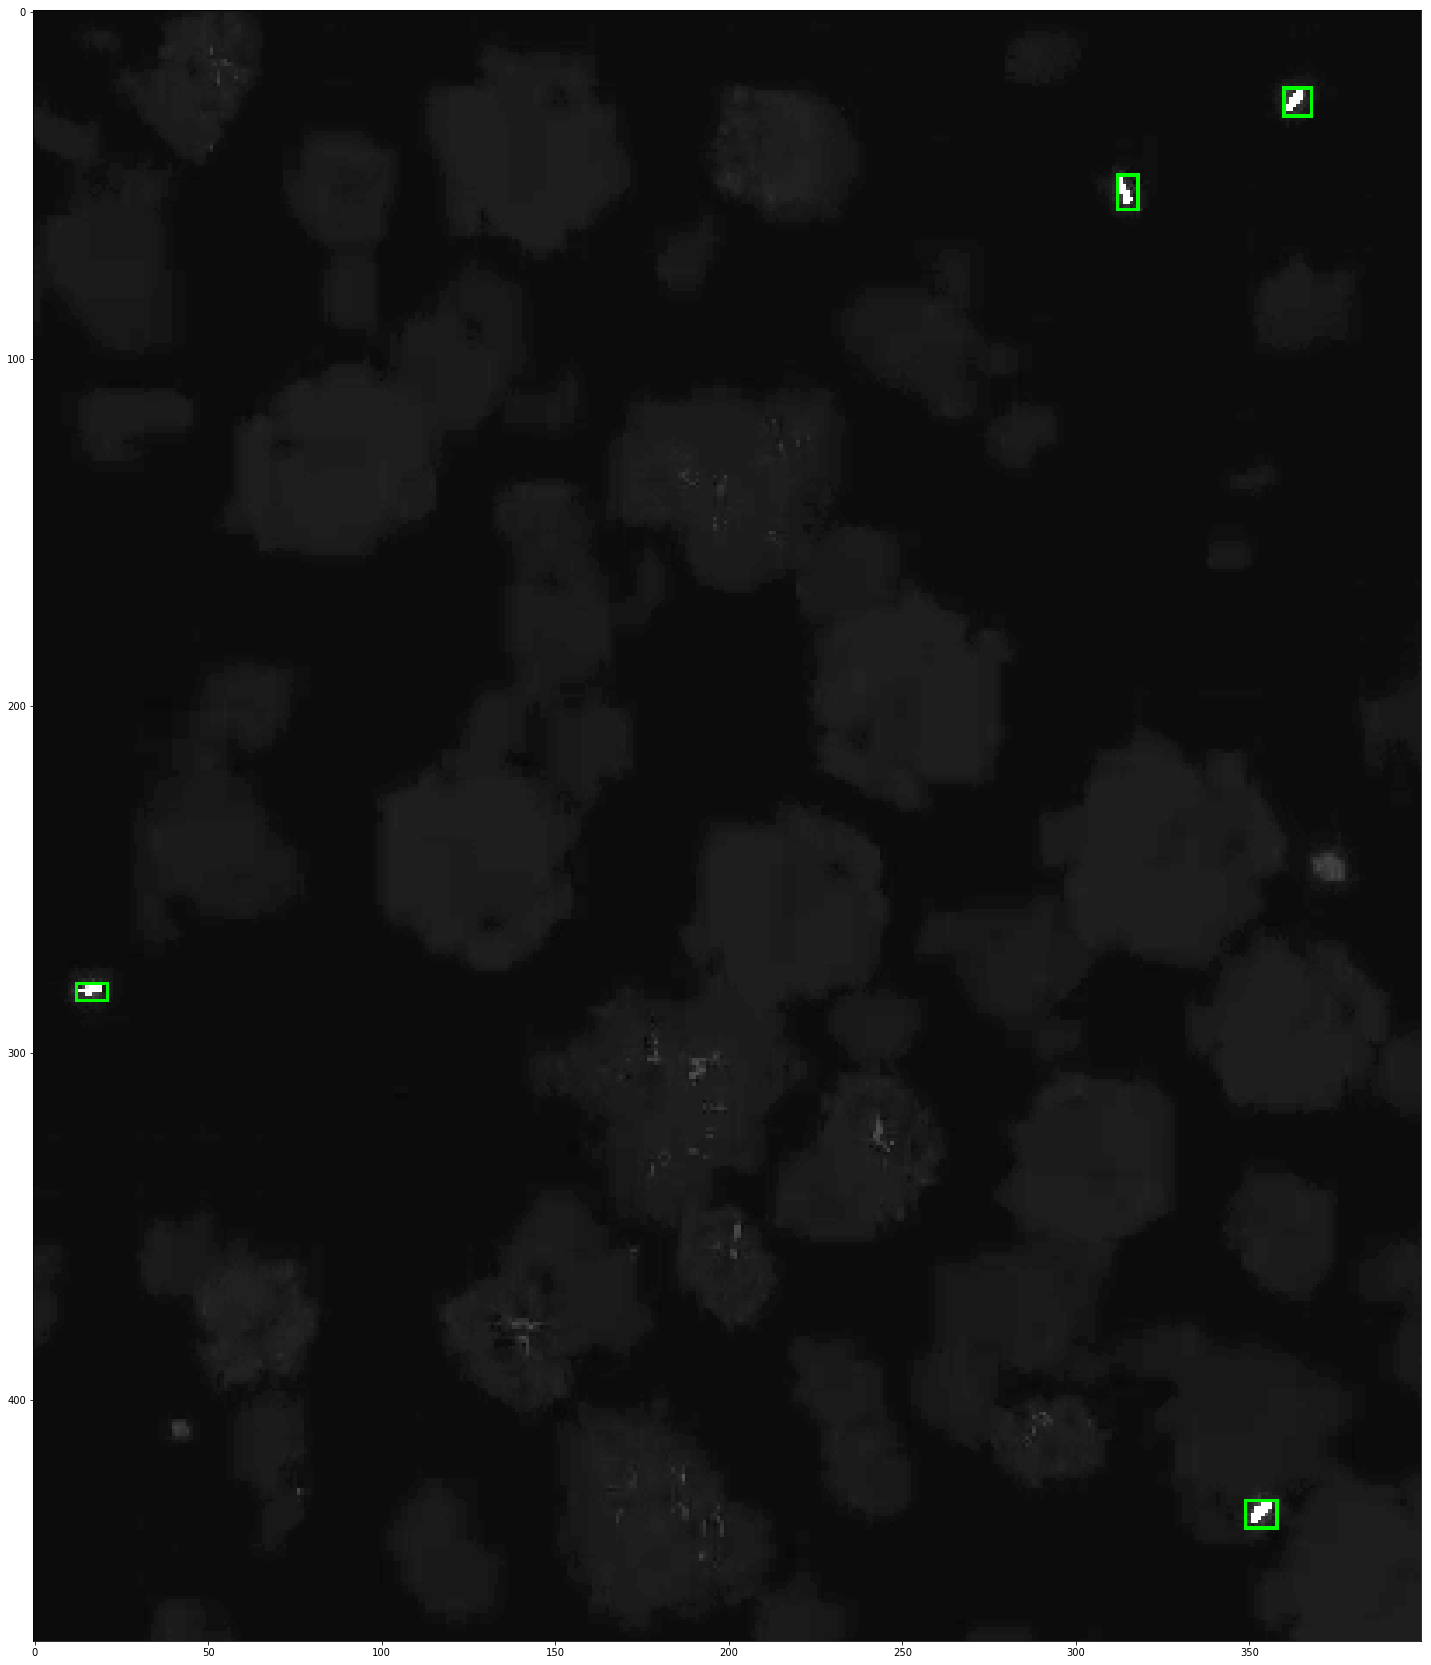

In [118]:
plt.figure(figsize=(30,30))
bb = find_bboxes(frame, test_interest_objs)
plt.imshow(draw_bboxes(increase_brightness(frame,128), bb)[250:,400:800], cmap='gray')

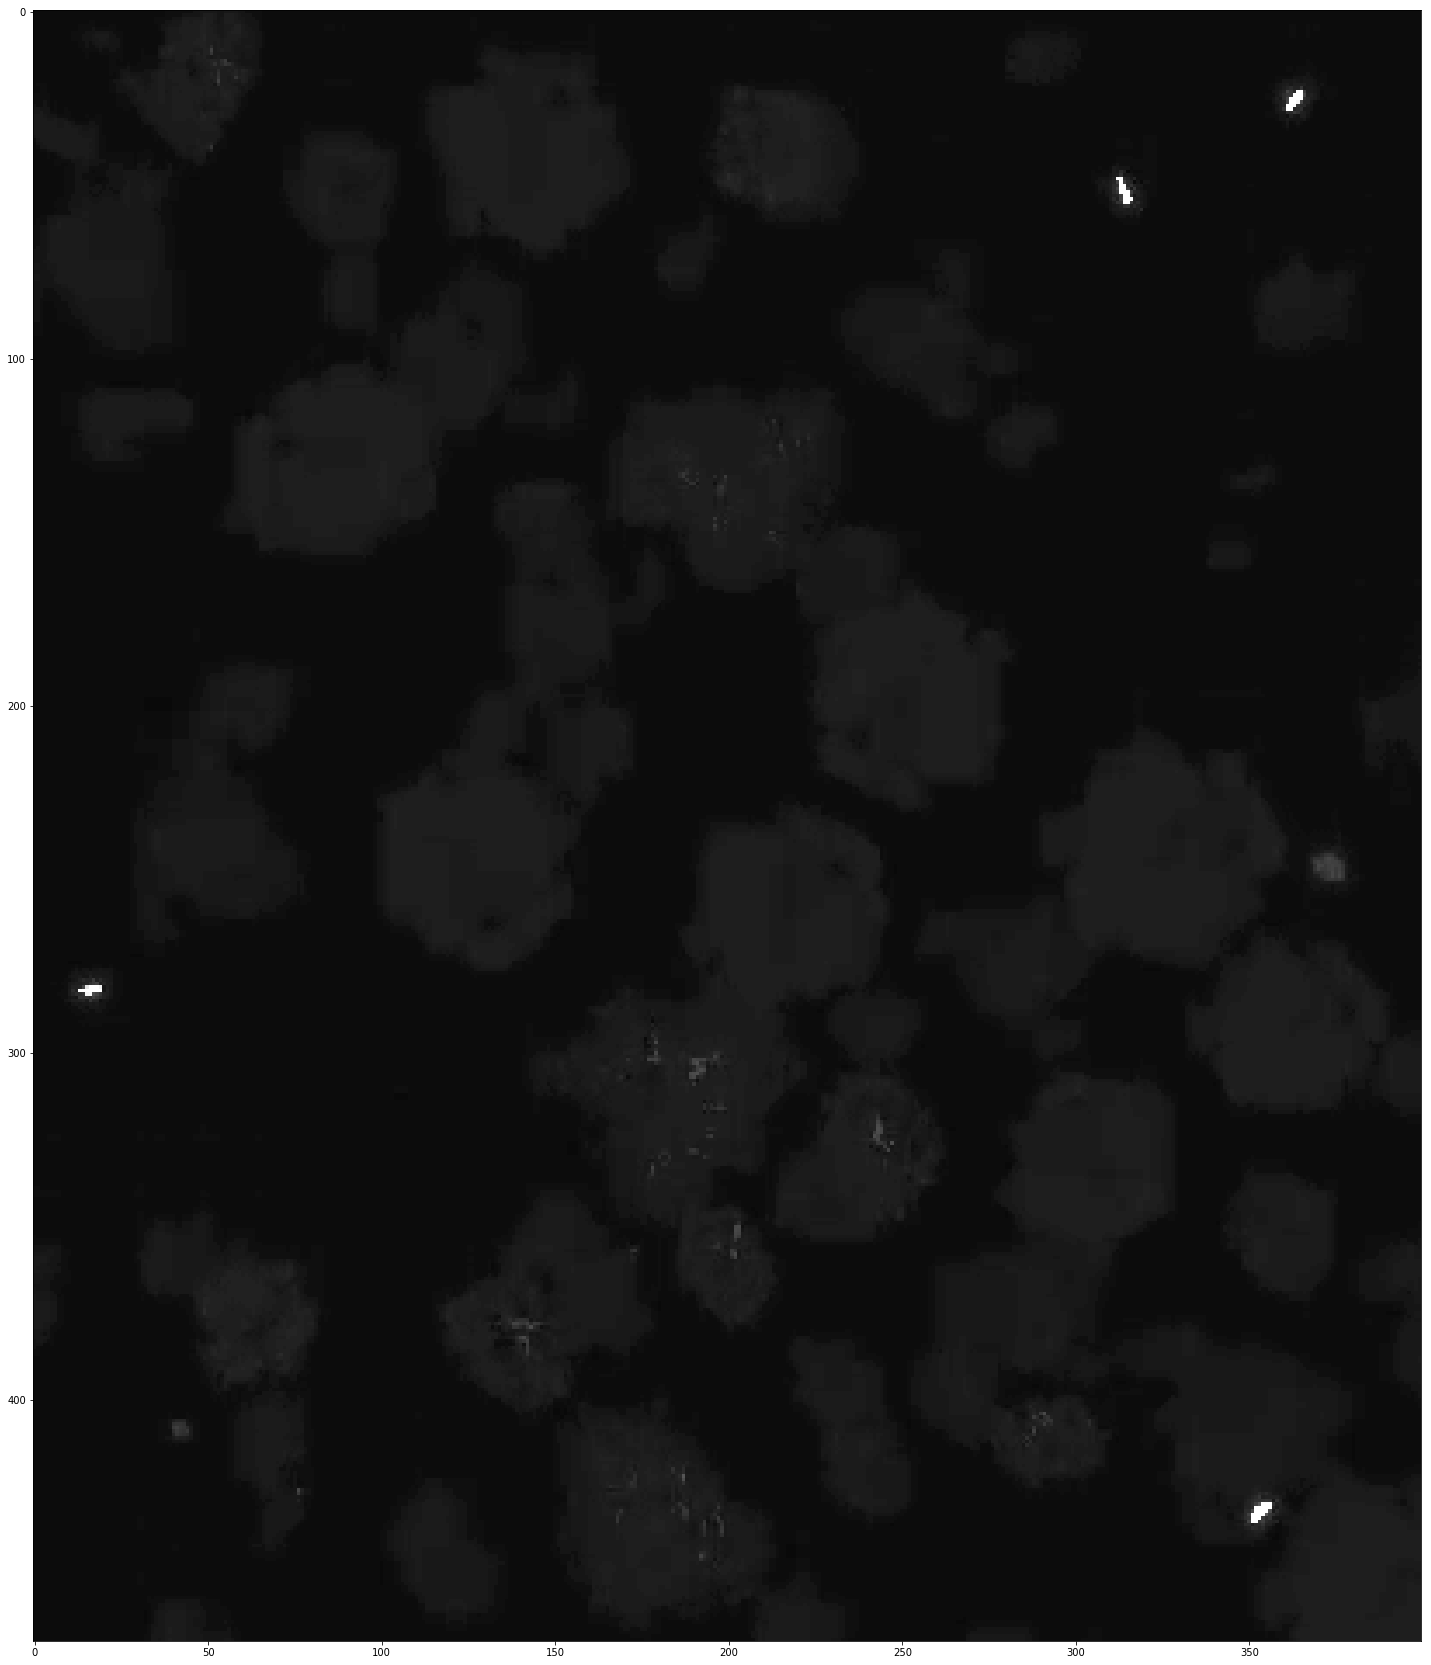

In [148]:
plt.figure(figsize=(30,30))
f = frame.copy()
#f = ((f - f.min()) / (f.max() - f.min()) * 255).astype(np.uint8)
f = increase_brightness(f, 128)
f = ((f - f.min()) / (f.max() - f.min()) * 255).astype(np.uint8)
plt.imshow(f[250:,400:800])